<a href="https://colab.research.google.com/github/SultanDaffaN/Data-Mining-Class/blob/main/Tutorial/1.%20EDA/tutorial_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Python for Data Science: Hands-on Regression

By Alfan F. Wicaksono
(Fakultas Ilmu Komputer, UI)

<br/>

Beberapa bagian kode merupakan modifikasi dari:

https://www.tensorflow.org/tutorials/keras/regression


In [ ]:
!pip install -q seaborn

In [ ]:
import matplotlib.pyplot as plt
import io
import numpy as np
import pandas as pd # pengelolaaan data tabular
import seaborn as sns # untuk visualisasi
import tensorflow as tf # untuk numerical analysis --> mendukung komputasi paralel

import statsmodels.formula.api as smf # tools untuk beberapa statistik yang berguna untuk analisis data
import statsmodels.api as sm

from tensorflow import keras
from tensorflow.keras import layers

from sklearn import feature_selection # tools untuk machine learning
from sklearn import ensemble

plt.style.use('classic')
%matplotlib inline

# potongan kode di bawah adalah agar gambar graph yang 
# dihasilkan mempunyai kualitas yang cukup baik
sns.set(rc={"figure.dpi":100, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

# Dataset

https://archive.ics.uci.edu/ml/datasets/auto+mpg

This dataset is a slightly modified version of the dataset provided in the StatLib library. In line with the use by Ross Quinlan (1993) in predicting the attribute "mpg", 8 of the original instances were removed because they had unknown values for the "mpg" attribute. The original dataset is available in the file "auto-mpg.data-original".

"The data concerns city-cycle fuel consumption in **miles per gallon (MPG)**, to be predicted in terms of 3 multivalued discrete and 5 continuous attributes." (Quinlan, 1993)

Attribute Information:

1. mpg: continuous
2. cylinders: multi-valued discrete
3. displacement: continuous
4. horsepower: continuous
5. weight: continuous
6. acceleration: continuous
7. model year: multi-valued discrete
8. origin: multi-valued discrete
9. car name: string (unique for each instance)


In [ ]:
!wget -c http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data

--2021-12-08 06:35:01--  http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [ ]:
column_names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
                'acceleration', 'model_year', 'origin', 'car_name']

# file auto-mpg.data masih mengandung karakter tabulasi
# yang ada mengganggu proses parsing. Saat parsing, kita
# akan menggunakan delimiter yang berupa space dengan
# skipinitialspace
#
# kita asumsikan ukuran file auto-mpg.data tidak terlalu
# besar sehingga masih muat di memori internal
with open("auto-mpg.data") as file:
  content = file.read().replace("\t", " ")

original_dataset = pd.read_csv(io.StringIO(content), names=column_names, 
                               na_values='?', sep=' ',
                               skipinitialspace=True)

original_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car_name      398 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 28.1+ KB


# Pre-Processing Data

Kita ingin menjaga agar original dataset tidak berubah saat melakukan preprocessing atau analysis. Preprocessing dan exploratory data analysis akan menggunakan dataset baru hasil copy dari original dataset.

In [ ]:
dataset = original_dataset.copy()
dataset.head(15)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino
5,15.0,8,429.0,198.0,4341.0,10.0,70,1,ford galaxie 500
6,14.0,8,454.0,220.0,4354.0,9.0,70,1,chevrolet impala
7,14.0,8,440.0,215.0,4312.0,8.5,70,1,plymouth fury iii
8,14.0,8,455.0,225.0,4425.0,10.0,70,1,pontiac catalina
9,15.0,8,390.0,190.0,3850.0,8.5,70,1,amc ambassador dpl


Kolom carname sepertinya bersifat "hampir" unik untuk setiap instance sehingga kemungkinan besar kita tidak gunakan dalam tahapan data analysis.

Kemudian, kolom cylinders, model_year, dan origin bertipe int64. Kolom model_year dan cylinders bersifat diskrit dan ordinal, artinya nilai-nilainya dapat diurutkan. Untuk kolom origin, kemungkinan besar bersifat kategorikal (asal negara atau wilayah yang memproduksi mobil, seperti eropa, amerika, dan jepang). Kita perlu periksa terlebih dahulu dengan cara melihat banyaknya nilai unik.

In [ ]:
print("# unique values for car_name  : ", dataset["car_name"].nunique())
print("# unique values for cylinders : ", dataset["cylinders"].nunique())
print("# unique values for model_year: ", dataset["model_year"].nunique())
print("# unique values for origin    : ", dataset["origin"].nunique())

# unique values for car_name  :  305
# unique values for cylinders :  5
# unique values for model_year:  13
# unique values for origin    :  3


Kita dapat lihat sepertinya kolom origin = 1 berisi mobil-mobil yang berasal dari pabrikan amerika serikat, dan 2 adalah eropa, serta 3 adalah jepang. Untuk membuat visualisasi yang lebih baik, kita beri nama ulang kolom origin dengan nama negara asal pabrikan.

In [ ]:
dataset['origin'] = dataset['origin'].map({1: 'USA', 2: 'europe', 3: 'japan'})

In [ ]:
dataset.tail(10)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
388,26.0,4,156.0,92.0,2585.0,14.5,82,USA,chrysler lebaron medallion
389,22.0,6,232.0,112.0,2835.0,14.7,82,USA,ford granada l
390,32.0,4,144.0,96.0,2665.0,13.9,82,japan,toyota celica gt
391,36.0,4,135.0,84.0,2370.0,13.0,82,USA,dodge charger 2.2
392,27.0,4,151.0,90.0,2950.0,17.3,82,USA,chevrolet camaro
393,27.0,4,140.0,86.0,2790.0,15.6,82,USA,ford mustang gl
394,44.0,4,97.0,52.0,2130.0,24.6,82,europe,vw pickup
395,32.0,4,135.0,84.0,2295.0,11.6,82,USA,dodge rampage
396,28.0,4,120.0,79.0,2625.0,18.6,82,USA,ford ranger
397,31.0,4,119.0,82.0,2720.0,19.4,82,USA,chevy s-10


Untuk mengetahui missing values:

In [ ]:
dataset.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
car_name        0
dtype: int64

Di kolom horsepower ada 6 instance yang nilainya missing. Kita coba estimasi missing values tersebut dengan interpolasi.

In [ ]:
dataset = dataset.interpolate(method ='linear')

In [ ]:
dataset.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model_year      0
origin          0
car_name        0
dtype: int64

# Exploratory Data Analysis

Setelah kita memuat dataset dan melakukan sedikit pre-processing terhadap data, sekarang kita mencoba untuk melakukan exploratory analysis untuk melihat distribusi masing-masing variable (baik yang bersifat kategorikal maupun yang tidak), dan juga multivariate analysis sederhana untuk melihat hubungan antara beberapa variable dengan tools seperti scatter-plot, korelasi, dan cat-plot.

Sebelumnya, kita perlu pisahkan terlebih dahulu testing portion dari dataset karena testin dataset akan digunakan untuk menguji predictive regression model nantinya. Kita tidak akan melakukan exploratory analysis dengan testing dataset ini.

In [ ]:
train_dataset = dataset.sample(frac = 0.80)
test_dataset = dataset.drop(train_dataset.index)


# kita akan lakukan EDA di train_dataset, bukan di test_dataset

## Barplot frekuensi cylinders (categorical)

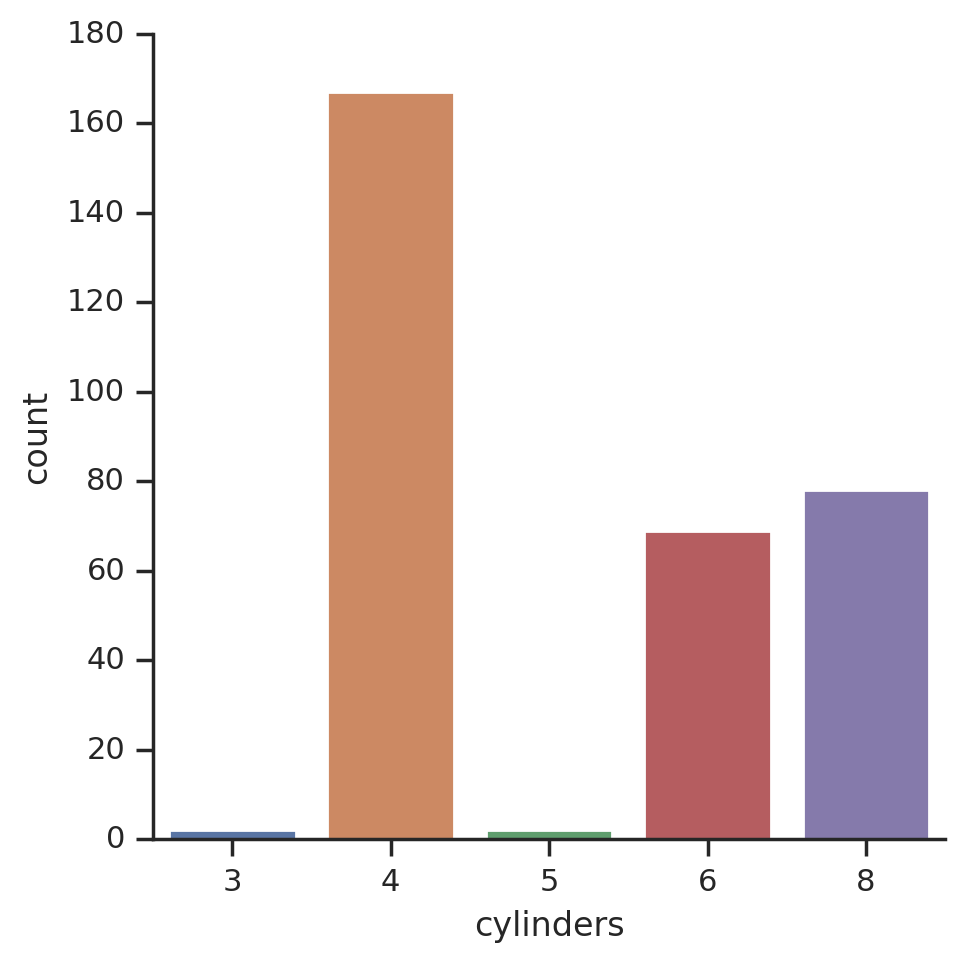

In [ ]:
sns.catplot(x = "cylinders", data = train_dataset, \
            kind = "count")

## Barplot frekuensi cylinders (stratified by origin)

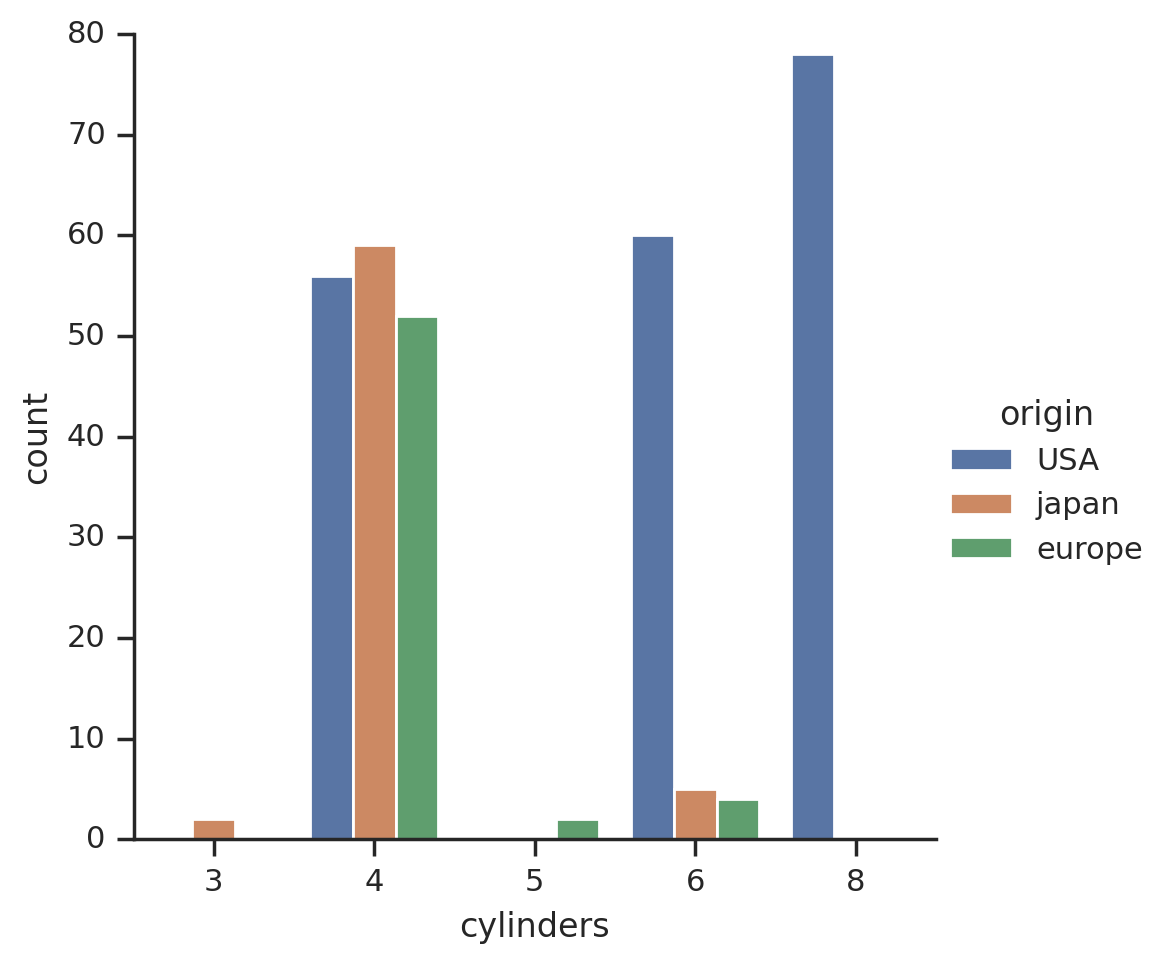

In [ ]:
sns.catplot(x = "cylinders", data = train_dataset, \
            kind = "count", hue = 'origin')

## Barplot frekuensi model_year

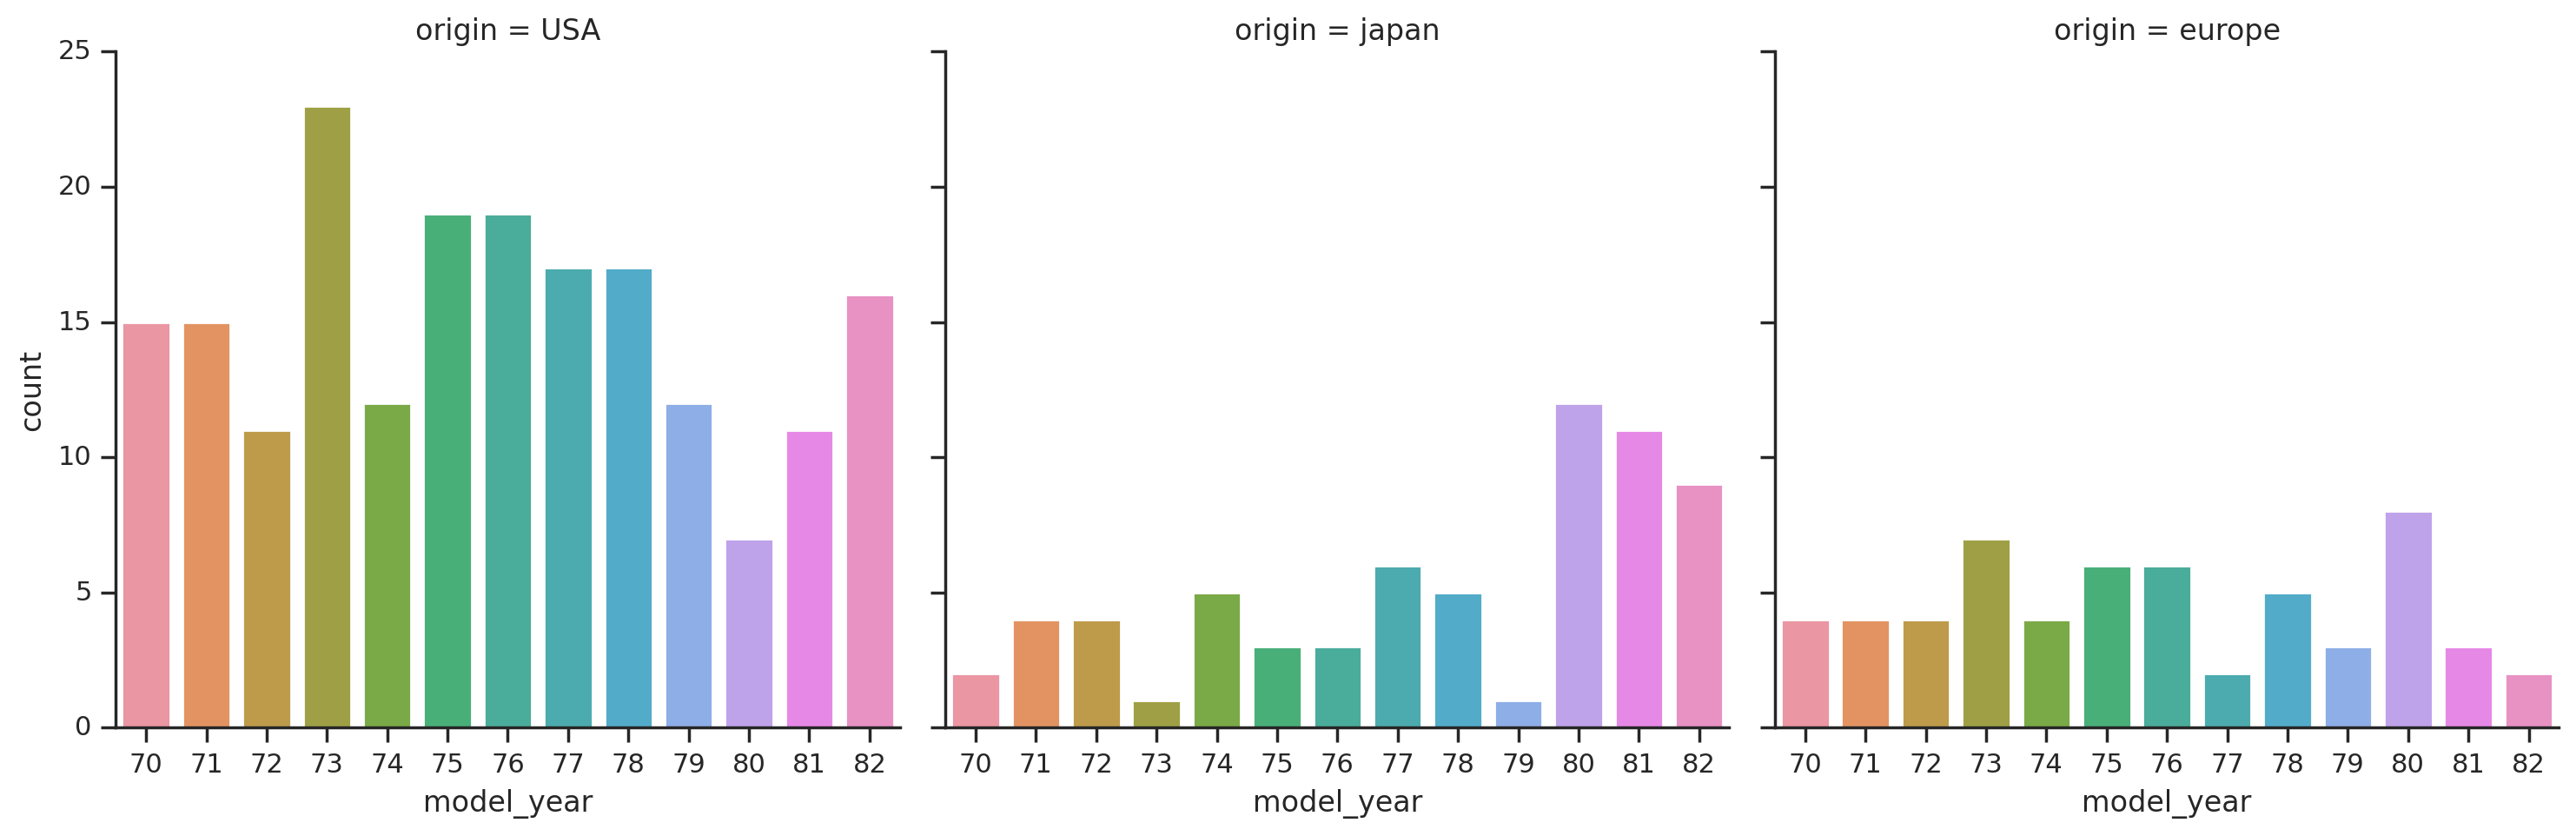

In [ ]:
sns.catplot(x = "model_year", data = train_dataset, \
            kind = "count", col = 'origin')

## Scatter plot pada numerical columns

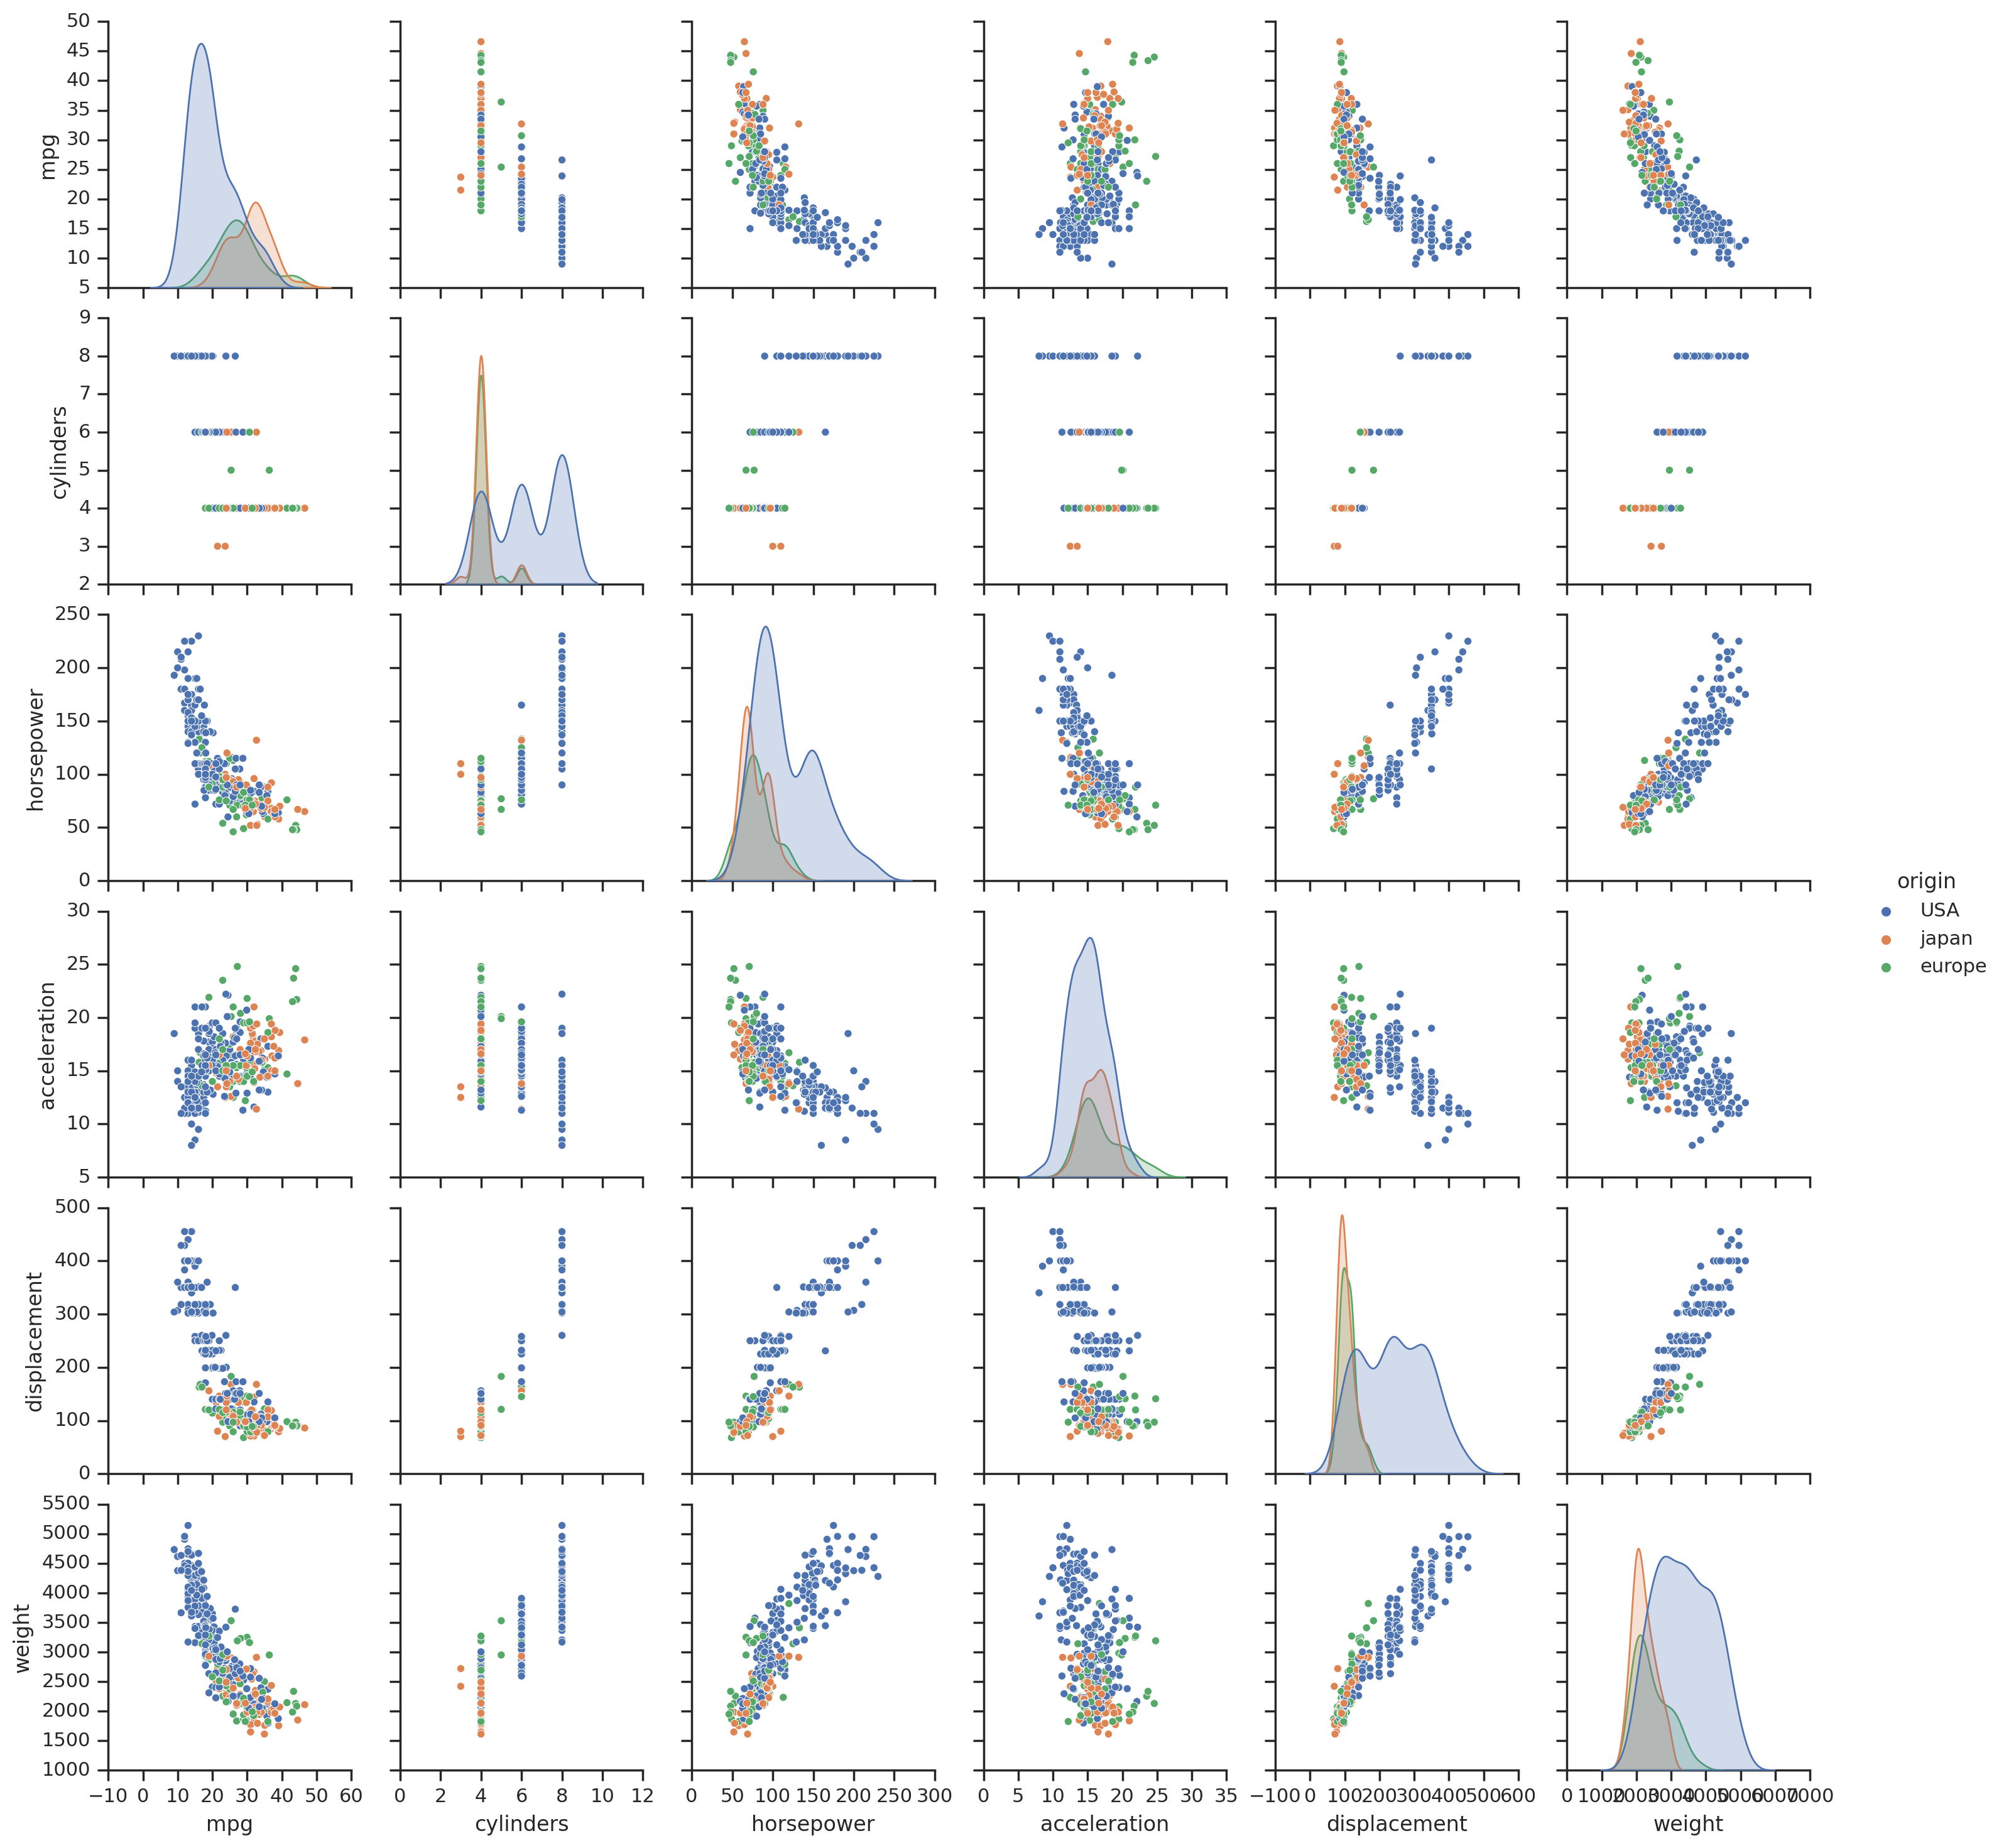

In [ ]:
sns.pairplot(train_dataset[['mpg', 'cylinders', 'horsepower', 'acceleration', \
                            'displacement', 'weight', 'origin']], hue = 'origin' ,\
                            diag_kind = 'kde')


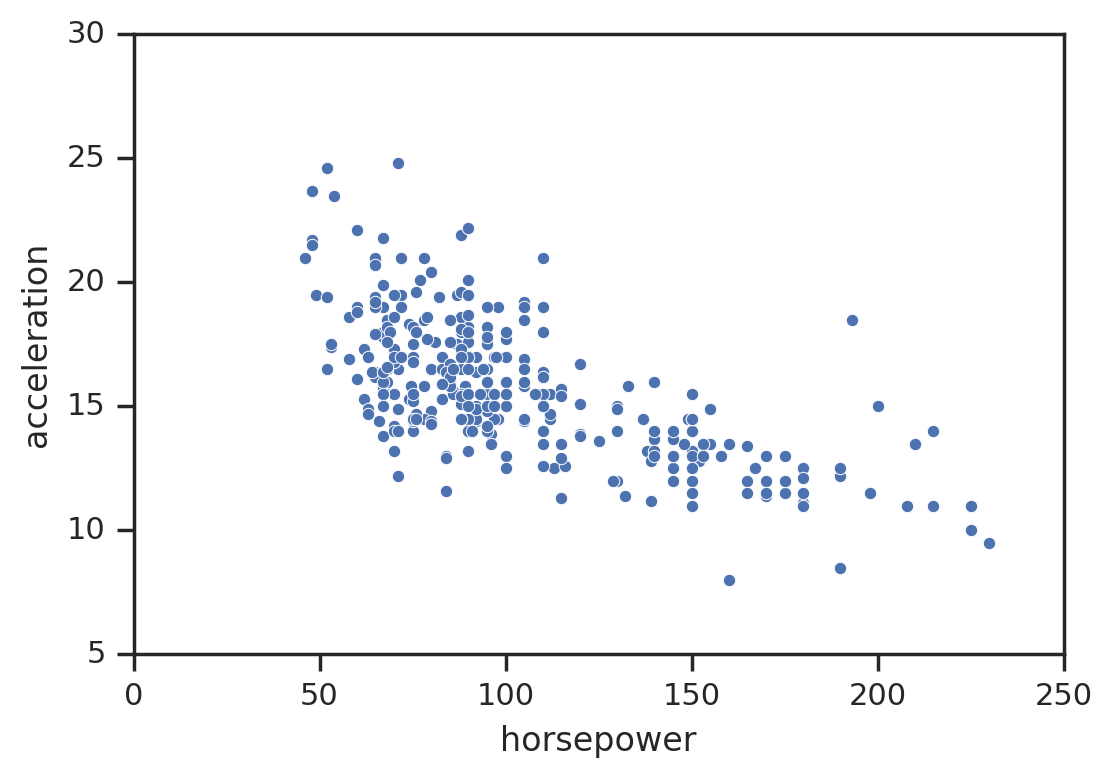

In [ ]:
sns.scatterplot(data = train_dataset, x = "horsepower", y = "acceleration")

## Apakah ada Multicollinearity?

Kita akan melihat apakah numerical variables seperti horsepower, acceleration, displacement, dan weight menampilkan multicollinearity. Dalam kasus regression (linear regression), seandainya kolom mpg merupakan dependent variable (response) dan yang lainnya merupakan independent variable (explanatory variable), maka seharusnya tidak boleh ada multicollinearity antar explanatory variables-nya.

### Hubungan antar numerical variables

Kode di bawah adalah untuk melihat korelasi (Pearson's correlation) antar numerical variables saja. Untuk yang melibatkan kategorikal akan di bahas di step berikutnya.

In [ ]:
corr_matrix = train_dataset[['mpg', 'horsepower', 'acceleration', 'displacement', 'weight']].corr(method = "pearson")
print(corr_matrix)

                   mpg  horsepower  acceleration  displacement    weight
mpg           1.000000   -0.780228      0.398168     -0.823116 -0.842897
horsepower   -0.780228    1.000000     -0.664903      0.892049  0.873251
acceleration  0.398168   -0.664903      1.000000     -0.516040 -0.392411
displacement -0.823116    0.892049     -0.516040      1.000000  0.939983
weight       -0.842897    0.873251     -0.392411      0.939983  1.000000


Text(0.5, 1.0, 'pearson correlation')

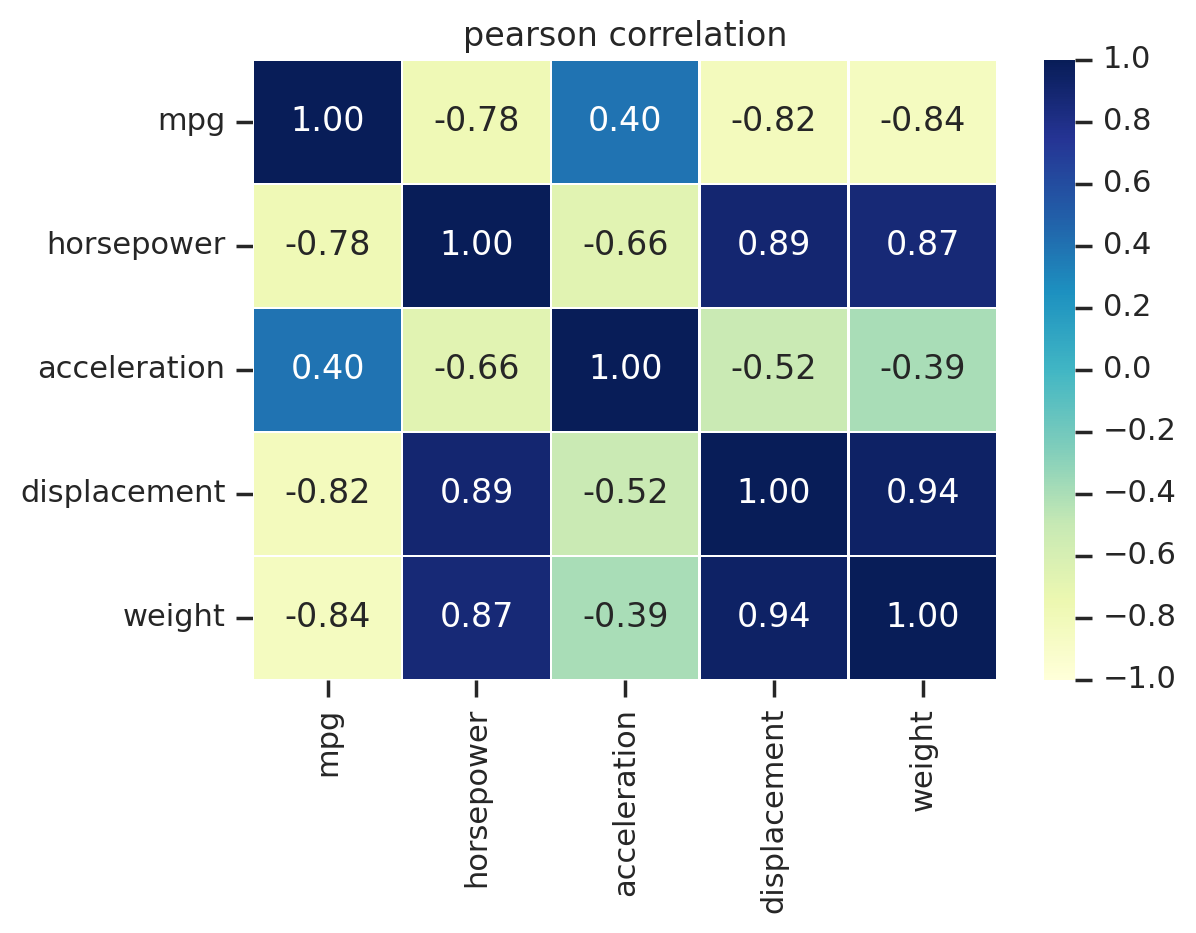

In [ ]:
sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5)
plt.title("pearson correlation")

Kita dapat lihat bahwa seandainya mpg dijakan target prediksi (dengan linear regression), numerical variables weight, horsepower, dan displacement mendemonstrasikan multicollinearity. Mereka mempunyai relationship yang kuat.

### Hubungan antara numerical & categorical variables

Lalu, bagaimana dengan categorical variable seperti origin? apakah ia mempunyai relationship yang kuat juga dengan beberapa numerical variables, seperti weight, horsepower, dan displacement. Kita coba lihat hal tersebut secara visual terlebih dahulu:

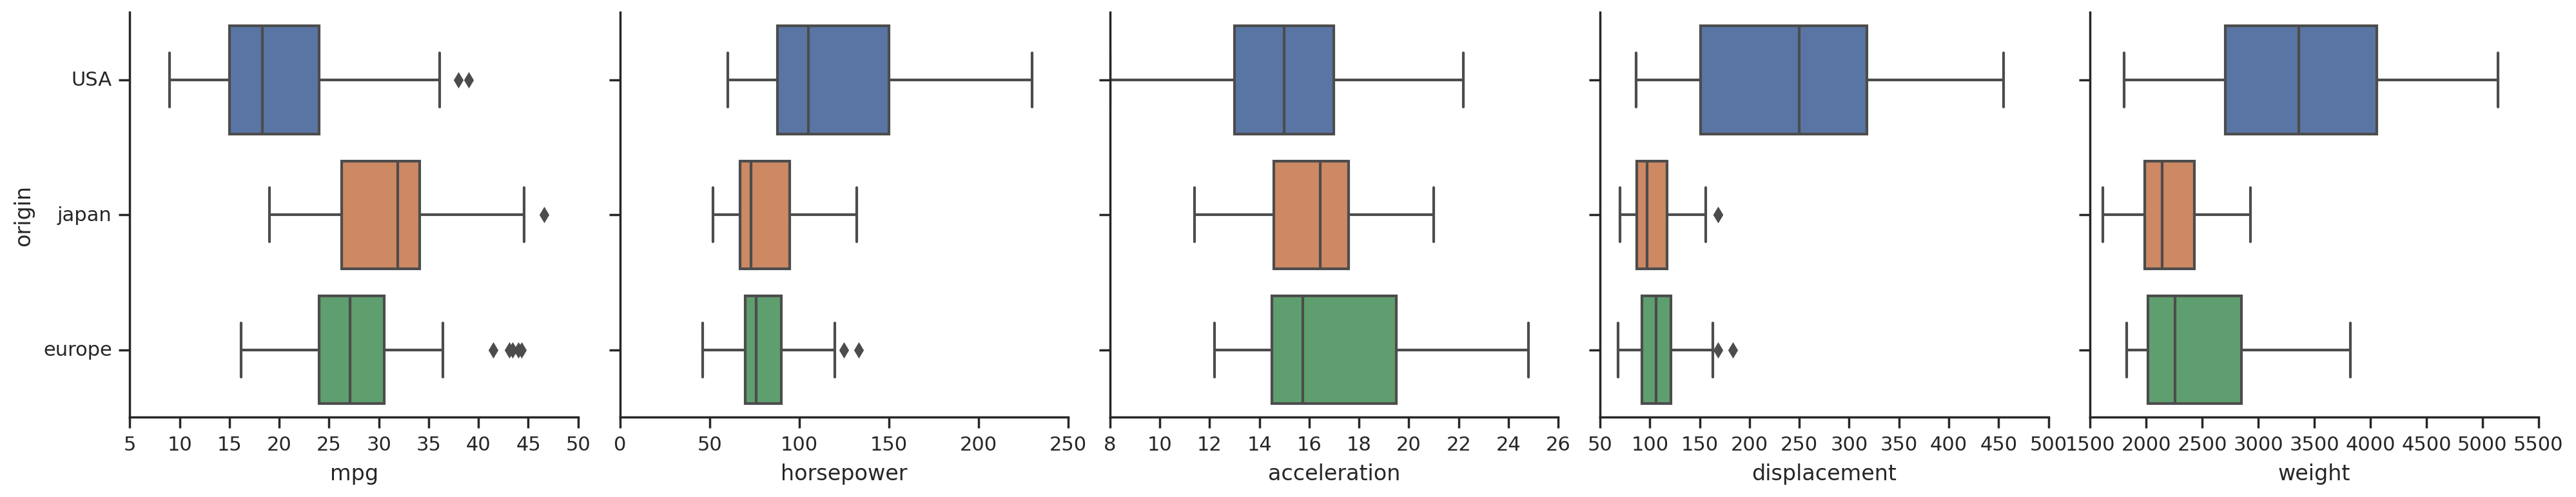

In [ ]:
# untuk membuat pair grid
# https://seaborn.pydata.org/tutorial/axis_grids.html
g = sns.PairGrid(train_dataset, y_vars = ["origin"], \
                 x_vars = ['mpg', 'horsepower', 'acceleration', 'displacement', 'weight'], height = 4)
g.map(sns.boxplot, orient = "h")

# notes: kita tidak bisa gabung catplot dengan PairGrid karena catplot pada
# dasarnya juga sudah memanfaatkankan atau mengimplementasikan fungsionalitas
# sejenis PairGrid

Terkadang, kita tidak terlalu percaya dengan visual results. Kita perlu sebuah pengukuran kuantitatif yang dapat diandalkan terkait apakah ada hubungan antara sebuah numerical variable dengan categorical variable. One-way ANOVA (analysis of variance) adalah sebuah uji statistik yang biasa digunakan untuk mengetahui apakah ada perbedaan signifikan antara rata-rata dari sebuah numerical variable untuk (atau jika distratifikasi) setiap nilai pada sebuah categorical variable. One-way ANOVA menggunakan F-test:

1. H0: numerical dan categorical variables tidak berhubungan
2. Terima H0 jika P-Value > 0.05
3. Tolak H0 jika P-Value < 0.05, yang berarti kita menemukan empirical evidence (not a proof!!) bahwa kedua variable tersebut memang berhubungan.

Sebagai contoh:

In [ ]:
model = smf.ols('mpg ~ C(origin)', data = train_dataset).fit()
table = sm.stats.anova_lm(model)
print(table)

             df        sum_sq      mean_sq          F        PR(>F)
origin      2.0   7072.309034  3536.154517  85.022235  2.973836e-30
Residual  315.0  13101.145557    41.590938        NaN           NaN


Pada hasil ANOVA test di atas, kita dapat lihat bahwa p-value (PR(>F)) < 0.05. Artinya, kita mendapatkan empirical support dari data bahwa ada perbedaan rata-rata nilai mpg untuk setiap nilai origin. Artinya, kita mempunyai empirical support bahwa mereka mempunyai hubungan.

Sekarang kita coba untuk numerical variables yang lain:

In [ ]:
for col in ['horsepower', 'acceleration', 'displacement', 'weight']:
  string = col + ' ~ C(origin)'
  model = smf.ols(string, data = train_dataset).fit()
  table = sm.stats.anova_lm(model)
  print(string + ':')
  print(table)
  print()

horsepower ~ origin:
             df         sum_sq       mean_sq          F        PR(>F)
origin      2.0  110405.433532  55202.716766  49.871377  1.526687e-19
Residual  315.0  348674.063323   1106.901788        NaN           NaN

acceleration ~ origin:
             df       sum_sq    mean_sq          F    PR(>F)
origin      2.0   185.524846  92.762423  13.109127  0.000003
Residual  315.0  2228.993896   7.076171        NaN       NaN

displacement ~ origin:
             df        sum_sq        mean_sq           F        PR(>F)
origin      2.0  1.431404e+06  715701.922848  122.393044  4.682000e-40
Residual  315.0  1.841985e+06    5847.570261         NaN           NaN

weight ~ origin:
             df        sum_sq       mean_sq         F        PR(>F)
origin      2.0  8.401799e+07  4.200900e+07  89.87867  1.309584e-31
Residual  315.0  1.472300e+08  4.673967e+05       NaN           NaN



Sebelumnya kita sudah melihat bagaimana One-way ANOVA berguna untuk melihat hubungan satu arah antara categorical variable dengan numerical dependent variable.

Terkadang sebuah dependent variable mungkin saja dipengaruhi oleh interaksi antara dua buah categorical variables. Sebagai contoh, kita ingin mengetahui apakah interaksi antara cylinders dan origin (dua-duanya merupakan categorical variables) mempunyai pengaruh terhadap mpg. Kita bisa menggunakan Two-way ANOVA dalam hal ini.

In [ ]:
# two way ANOVA
# mpg ~ origin + C(cylinders) + origin:C(cylinders) sama dengan
# mpg ~ origin * C(cylinders)
# look at https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/lm
model = smf.ols('mpg ~ origin + C(cylinders) + origin:C(cylinders)', data = train_dataset).fit()
table = sm.stats.anova_lm(model)
print(table)

                        df       sum_sq      mean_sq           F        PR(>F)
origin                 2.0  7072.309034  3536.154517  169.838226  1.738756e-50
C(cylinders)           4.0  6654.036372  1663.509093   79.896801  1.785484e-46
origin:C(cylinders)    8.0    31.349665     3.918708    0.188212  9.924291e-01
Residual             309.0  6433.603151    20.820722         NaN           NaN


Untuk mengkaji interaksi antar variable, silakan lihat


1.   https://www.marsja.se/three-ways-to-carry-out-2-way-anova-with-python/
2.   https://www.statsmodels.org/dev/examples/notebooks/generated/interactions_anova.html
3.   https://web.stanford.edu/class/stats191/notebooks/Interactions.html








# Regression as an Analysis Tool

Regression dapat digunakan sebagai alat untuk pengembangan sebuah predictive model, dan juga dapat digunakan sebagai alat analisis untuk mengetahui effect size dari sebuah factor terhadap response variable. Pada bagian ini, kita akan menggunakan Regression sebagai alat untuk mengetahui effect size setiap independent variables melalui estimated coefficients untuk masing-masing independent variables tersebut.

## Feature Selection

Agar bisa menggunakan Linear Regression sebagai alat untuk analisis efect size dari independent variables, kita perlu mengabaikan features yang collinear karena dapat memberikan estimated coefficients yang tidak akurat dan tidak bisa diinterpretasikan. Features yang collinear akan dipilih dengan menggunakan feature selection. Kita akan demonstrasikan dua buah cara untuk melakukan hal tersebut.

In [ ]:
# one-hot encoding terhadap kolom origin
train_dataset_for_selection = pd.get_dummies(train_dataset, columns=['origin'], prefix='', prefix_sep='')

# buat kolom car_name karena sangat unik
train_dataset_for_selection = train_dataset_for_selection.drop("car_name", axis = 1)

train_dataset_for_selection.tail()


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,USA,europe,japan
149,24.0,4,120.0,97.0,2489.0,15.0,74,0,0,1
289,16.9,8,350.0,155.0,4360.0,14.9,79,1,0,0
383,38.0,4,91.0,67.0,1965.0,15.0,82,0,0,1
89,15.0,8,318.0,150.0,3777.0,12.5,73,1,0,0
86,14.0,8,304.0,150.0,3672.0,11.5,73,1,0,0


In [ ]:
X = train_dataset_for_selection.drop("mpg", axis = 1).values
Y = train_dataset_for_selection["mpg"].values
feature_names = train_dataset_for_selection.drop("mpg", axis = 1).columns

print(X.shape)
print(Y.shape)
print(feature_names)

(318, 9)
(318,)
Index(['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration',
       'model_year', 'USA', 'europe', 'japan'],
      dtype='object')


### Selections based on P-Values

In [ ]:
# feature selection dengan ANOVA, terhadap mpg
# menghitung korelasi masing-masing explanatory variables dengan mpg
# lalu menghitung ANOVA F-test

TOP_K = 5

feature_selector = feature_selection.SelectKBest(score_func = feature_selection.f_regression, \
                                                 k = TOP_K).fit(X, Y)

print("TOP {} selected features: ".format(TOP_K))
print(feature_names[feature_selector.get_support()])
print()
print("P-values & Scores")
for i,feature_name in enumerate(feature_names):
  print("{:15s} p-value:{:<25s} score:{:<20f}".format(feature_name, \
                                                      str(feature_selector.pvalues_[i]), \
                                                      feature_selector.scores_[i]))

TOP 5 selected features: 
Index(['cylinders', 'displacement', 'horsepower', 'weight', 'model_year'], dtype='object')

P-values & Scores
cylinders       p-value:4.584234229474699e-69     score:524.080307          
displacement    p-value:1.2001686684002079e-79    score:663.903478          
horsepower      p-value:2.3191148289689033e-66    score:491.680949          
weight          p-value:4.696951371180625e-87     score:775.442989          
acceleration    p-value:1.5855228732911448e-13    score:59.536840           
model_year      p-value:8.07479028112397e-31      score:166.018547          
USA             p-value:5.240294957779959e-30     score:160.380352          
europe          p-value:7.892799374238274e-06     score:20.641266           
japan           p-value:3.20032624830956e-18      score:85.764780           


### Selections using Predictive Models

In [ ]:
predictive_model = ensemble.GradientBoostingRegressor()
predictive_model.fit(X, Y)

sorted_features = sorted(zip(feature_names, predictive_model.feature_importances_), \
                         key = lambda x: x[1], \
                         reverse = True)

for feature_name, score in sorted_features:
  print("{:<15} {:<.5f}".format(feature_name, score))

weight          0.40457
displacement    0.30645
model_year      0.12999
cylinders       0.08071
horsepower      0.04918
acceleration    0.02625
USA             0.00239
europe          0.00034
japan           0.00013


Kita ketahui bahwa weight, displacement, dan horsepower saling mempunyai korelasi yang tinggi dan sangat berpotensi untuk collinear. Oleh karena itu, kita harus pilih salah satu dari tiga variables ini untuk diikutsertakan dalam model. Berdasarkan hasil feature selection di atas, kita akan plih weight yang memiliki nilai importance paling tinggi.

## Linear Regression Analysis

Kita akan lihat bagaimana effect size dari weight, model_year, cylinders, dan acceleration terhadap mpg. Kali ini tiga kolom turunan dari kolom origin (USA, europe, dan japan) tidak kita ikutsertakan. Selain karena hasil one-way ANOVA test sebelumnya mengatakan bahwa kolom origin mempunyai relationship dengan beberapa numerical explanatory variables, tiga kolom turunan origin juga mempunyai nilai importance yang rendah dibandingkan yang lainnya berdasarkan perhitungan yang berbasis gradient boosting model.

Kalau untuk analysis, optimasi loss function (OLS) tidak boleh melibatkan regularization agar coefficient yang dihasilkan akurat dan merefleksikan effect size dari factor tertentu.

In [ ]:
# one-hot encoding terhadap kolom origin
train_dataset_for_analysis = pd.get_dummies(train_dataset, columns=['origin'], prefix='', prefix_sep='')

model = smf.ols('mpg ~ weight + model_year + cylinders + acceleration', \
                data = train_dataset_for_analysis).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     350.5
Date:                Wed, 08 Dec 2021   Prob (F-statistic):          3.11e-114
Time:                        06:35:20   Log-Likelihood:                -840.61
No. Observations:                 318   AIC:                             1691.
Df Residuals:                     313   BIC:                             1710.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -13.1455      4.718     -2.786   

Nilai R-squared (dan versi adjusted) adalah tidak relevant dalam kasus kali ini karena kita hanya ingin mengetahui hubungan antara independent dan dependent variable, bukan untuk mengembangkan model untuk memprediksi dependent variable. Signifikansi hubungan antara independent dan dependent variable tidak akan berubah walaupun nilai R-squared adalah 15% atau 90%.

Dalam hal ini, yang paling penting adalah **coefficient** dan nilai **p-value**. Coefficient menandakan seberapa unit mean dari response variable berubah ketika sebuah independent variable terkait berubah 1 uni. **p-value** menandakan seberapa significant coefficient dari sebuah independent variable berbeda dari 0 (p-value untuk test H0: coefficient = 0). Dari regression analysis di atas, dapat kita sampaikan beberapa hal berikut



1.   tidak cukup evidence untuk mengatakan bahwa cylinders dan acceleration adalah faktor yang mempengaruhi mpg (p-value > 0.05).
2.   sebaliknya, weight dan model_year adalah faktor yang mempengaruhi mpg (p-value < 0.05)
3.   kita dapat interpretasikan bahwa mean dari mpg naik sebesar 0.73 ketika nilai model_year naik sebesar 1 unit.
4.    kita dapat interpretasikan bahwa mean dari mpg turun sebesar 0.0067 ketika weight naik sebesar 1 unit.

Namun, seandainya nanti tujuan kita adalah untuk memprediksi dependent variable (dalam hal ini mpg), maka R-squared adalah salah satu patokan yang dapat kita gunakan untuk mengetahui seberapa fit model kita karena R-squared sejatinya adalah pengukuran error dari model. Nilai R-squared kecil artinya model menghasilkan error yang besar sehingga memberikan hasil prediksi yang kurang precise.

R-squared memiliki kecederungan untuk terus naik seiring bertambahnya independent variables yang diikutsertakan di dalam model. Ini adalah hal yang tidak baik karena bisa membuat salah paham bahwa model yang baik adalah model yang mempunyai independent variables yang sangat banyak. Inilah kelemahan dari R-squared yang diperbaiki oleh adjusted R-squared. Nilai adjusted R-squared akan menurun ketika penambahan independent variable tidak menyebabkan peningkatan model fit. Gunakan adjusted R-squared ketika kita membandingkan goodness-of-fit dari dua model dengan jumlah independent variable yang berbeda.


# Regression as a Prediction Tool

Kali ini, kita akan menggunakan Regression sebagai alat untuk memprediksi sebuah numerical variable. Berbagai macam tools dapat kita gunakan, mulai dari model OLS yang disediakan oleh statsmodel dan juga LinearRegression model yang disediakan oleh library SKlearn. Namun, kali ini kita akan menggunakan tensorflow dan keras untuk mengembangkan model regresi sendiri.

In [ ]:
# one-hot encoding terhadap kolom origin
train_dataset_for_prediction = pd.get_dummies(train_dataset, columns=['origin'], prefix='', prefix_sep='')
test_dataset_for_prediction = pd.get_dummies(test_dataset, columns=['origin'], prefix='', prefix_sep='')

# buat kolom car_name karena sangat unik
train_dataset_for_prediction = train_dataset_for_prediction.drop("car_name", axis = 1)
test_dataset_for_prediction = test_dataset_for_prediction.drop("car_name", axis = 1)

X = train_dataset_for_prediction.drop("mpg", axis = 1).values
Y = train_dataset_for_prediction["mpg"].values
X_test = test_dataset_for_prediction.drop("mpg", axis = 1).values
Y_test = test_dataset_for_prediction["mpg"].values

print(X.shape)
print(Y.shape)
print(X_test.shape)
print(Y_test.shape)

(318, 9)
(318,)
(80, 9)
(80,)


## Linear Model

In [ ]:
# layer Normalization
normalizer = keras.layers.Normalization(axis = -1)

# arsitektur model
linear_model = tf.keras.Sequential([
    normalizer,
    keras.layers.Dense(units = 1, \
                       kernel_regularizer = keras.regularizers.l2(0.01),
                       bias_regularizer = keras.regularizers.l2(0.01))
])


In [ ]:
# kompilasi model
linear_model.compile(
    optimizer = tf.optimizers.Adam(learning_rate = 0.01),
    loss = 'mean_absolute_error')

In [ ]:
%%time
history = linear_model.fit(X, Y, epochs = 200, \
                           verbose = 1, validation_split = 0.2)

Epoch 1/200
8/8 [==============================] - 1s 20ms/step - loss: 24.2519 - val_loss: 21.0485
Epoch 2/200
8/8 [==============================] - 0s 5ms/step - loss: 22.0062 - val_loss: 17.6857
Epoch 3/200
8/8 [==============================] - 0s 4ms/step - loss: 19.0368 - val_loss: 16.6172
Epoch 4/200
8/8 [==============================] - 0s 4ms/step - loss: 17.2691 - val_loss: 15.4775
Epoch 5/200
8/8 [==============================] - 0s 5ms/step - loss: 15.9333 - val_loss: 14.6384
Epoch 6/200
8/8 [==============================] - 0s 5ms/step - loss: 15.1394 - val_loss: 13.5208
Epoch 7/200
8/8 [==============================] - 0s 5ms/step - loss: 14.5200 - val_loss: 13.1843
Epoch 8/200
8/8 [==============================] - 0s 5ms/step - loss: 13.7290 - val_loss: 18.3676
Epoch 9/200
8/8 [==============================] - 0s 5ms/step - loss: 14.1508 - val_loss: 11.6706
Epoch 10/200
8/8 [==============================] - 0s 5ms/step - loss: 12.2739 - val_loss: 11.6347
Epoch 11

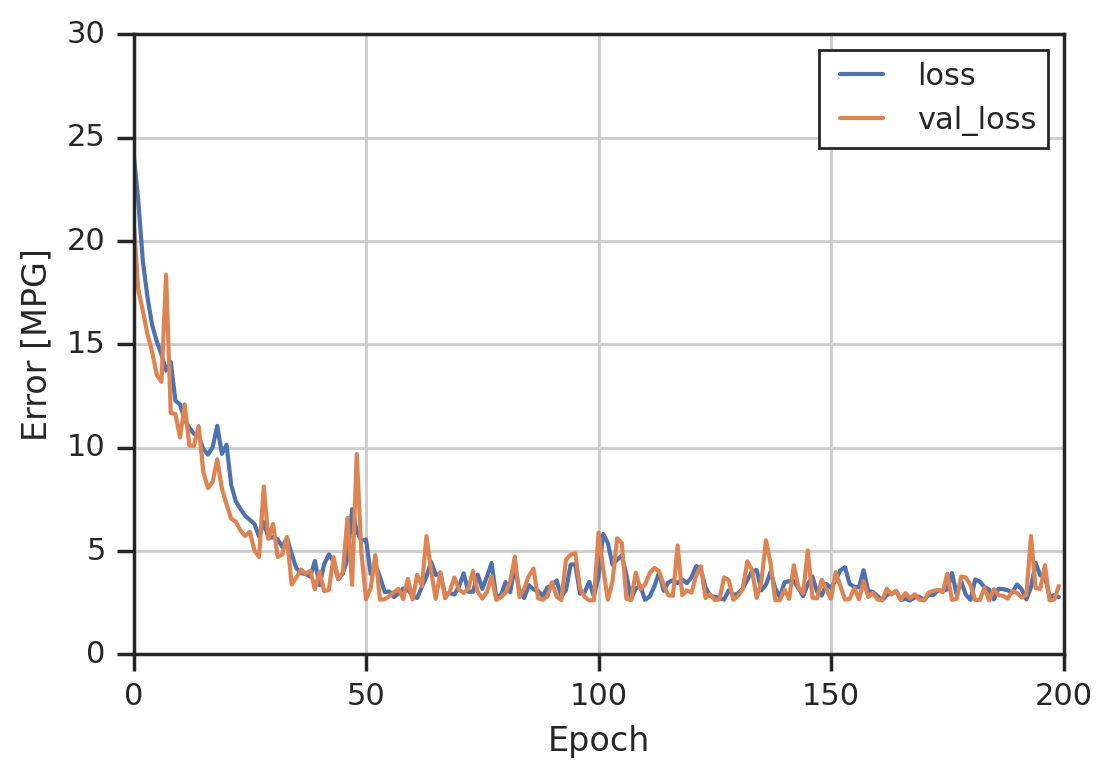

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label = 'loss')
  plt.plot(history.history['val_loss'], label = 'val_loss')
  plt.ylim([0, 30])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)


plot_loss(history)

In [ ]:
eval_results = {}

eval_results["linear_model"] = linear_model.evaluate(X_test, Y_test, verbose = 0)
print(eval_results["linear_model"])

3.358322858810425


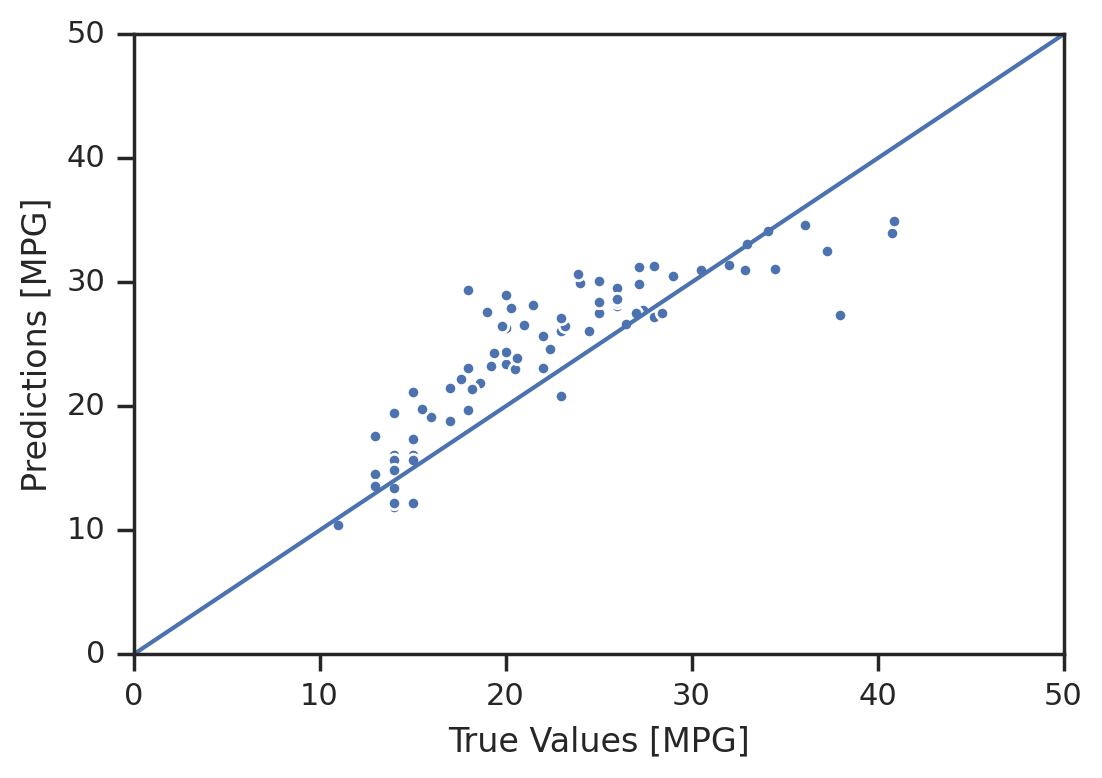

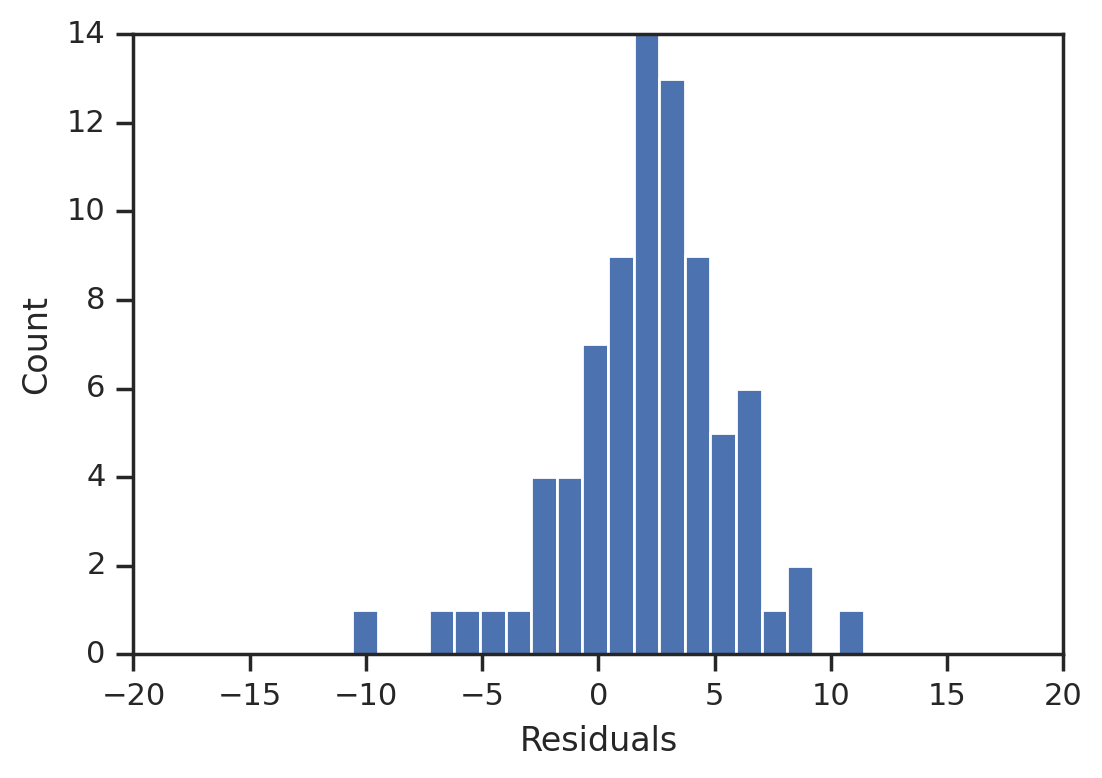

In [ ]:
# scatter plot antara Y_test dengan Y_predicted
def show_predicted_vs_true(Y_test, Y_predicted):
  plt.clf()
  plt.scatter(Y_test, Y_predicted)
  plt.xlabel('True Values [MPG]')
  plt.ylabel('Predictions [MPG]')
  lims = [0, 50]
  plt.xlim(lims)
  plt.ylim(lims)
  plt.plot(lims, lims)
  plt.show()

def prediction_error(Y_test, Y_predicted):
  plt.clf()
  residuals = Y_predicted - Y_test
  plt.hist(residuals, bins = 20)
  plt.xlabel('Residuals')
  plt.ylabel('Count')
  plt.xlim([-20, 20])
  plt.show()


Y_predicted = linear_model.predict(X_test).flatten()
show_predicted_vs_true(Y_test, Y_predicted)
prediction_error(Y_test, Y_predicted)

## Deep Neural Networks

In [ ]:
normalizer = keras.layers.Normalization(axis = -1)

regularizer = keras.regularizers.l2(0.001)

dnn_model = tf.keras.Sequential([
    normalizer,
    keras.layers.Dense(64, 
                       kernel_regularizer = regularizer,
                       bias_regularizer = regularizer,
                       activation = 'relu'),
    keras.layers.Dense(32, 
                       kernel_regularizer = regularizer,
                       bias_regularizer = regularizer,
                       activation = 'relu'),
    keras.layers.Dense(units = 1, \
                       kernel_regularizer = regularizer,
                       bias_regularizer = regularizer)
])

# compiling the model
dnn_model.compile(
    optimizer = tf.optimizers.Adam(learning_rate = 0.01),
    loss = 'mean_absolute_error')

# fitting
history = dnn_model.fit(X, Y, epochs = 200, \
                           verbose = 1, validation_split = 0.2)

Epoch 1/200
8/8 [==============================] - 1s 27ms/step - loss: 154.0167 - val_loss: 30.4367
Epoch 2/200
8/8 [==============================] - 0s 6ms/step - loss: 27.8958 - val_loss: 11.2846
Epoch 3/200
8/8 [==============================] - 0s 5ms/step - loss: 17.1833 - val_loss: 22.2054
Epoch 4/200
8/8 [==============================] - 0s 7ms/step - loss: 18.6834 - val_loss: 16.3888
Epoch 5/200
8/8 [==============================] - 0s 5ms/step - loss: 17.9598 - val_loss: 15.3836
Epoch 6/200
8/8 [==============================] - 0s 7ms/step - loss: 9.9098 - val_loss: 11.2819
Epoch 7/200
8/8 [==============================] - 0s 6ms/step - loss: 8.7061 - val_loss: 9.6416
Epoch 8/200
8/8 [==============================] - 0s 6ms/step - loss: 9.6961 - val_loss: 8.4251
Epoch 9/200
8/8 [==============================] - 0s 5ms/step - loss: 7.6115 - val_loss: 12.9361
Epoch 10/200
8/8 [==============================] - 0s 6ms/step - loss: 19.5944 - val_loss: 40.4787
Epoch 11/200


In [ ]:
eval_results["dnn_model"] = dnn_model.evaluate(X_test, Y_test, verbose = 0)
print(eval_results["dnn_model"])

4.260088920593262


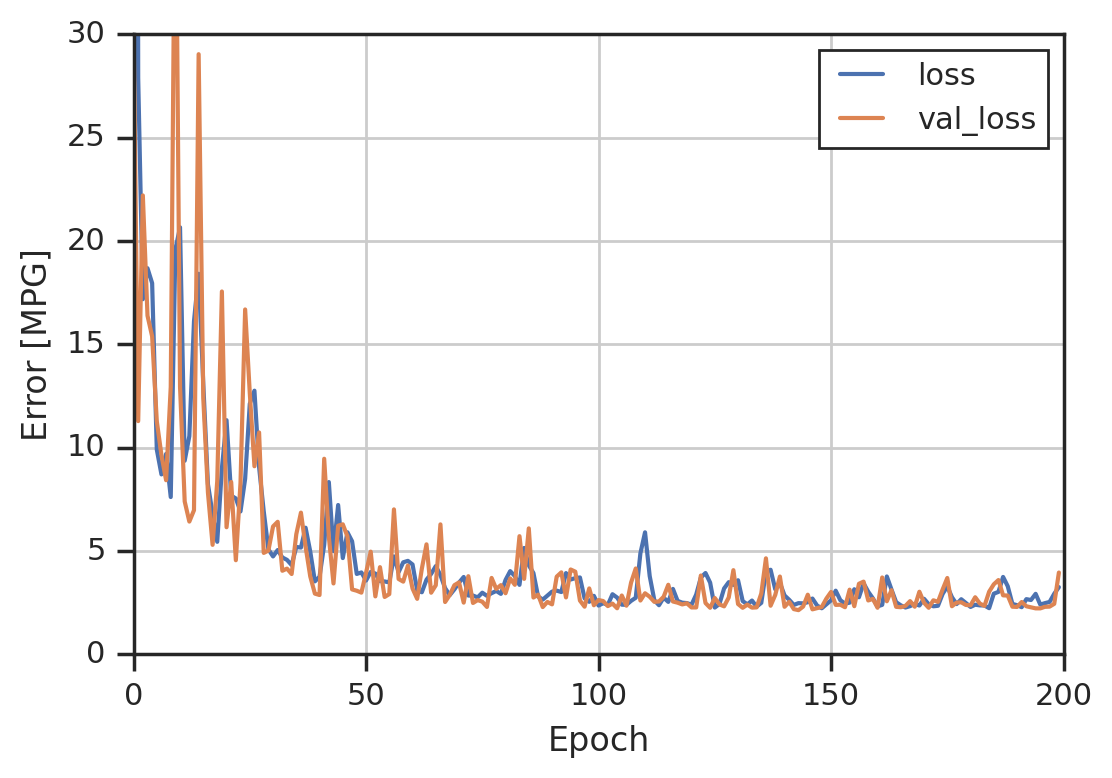

In [ ]:
plot_loss(history)

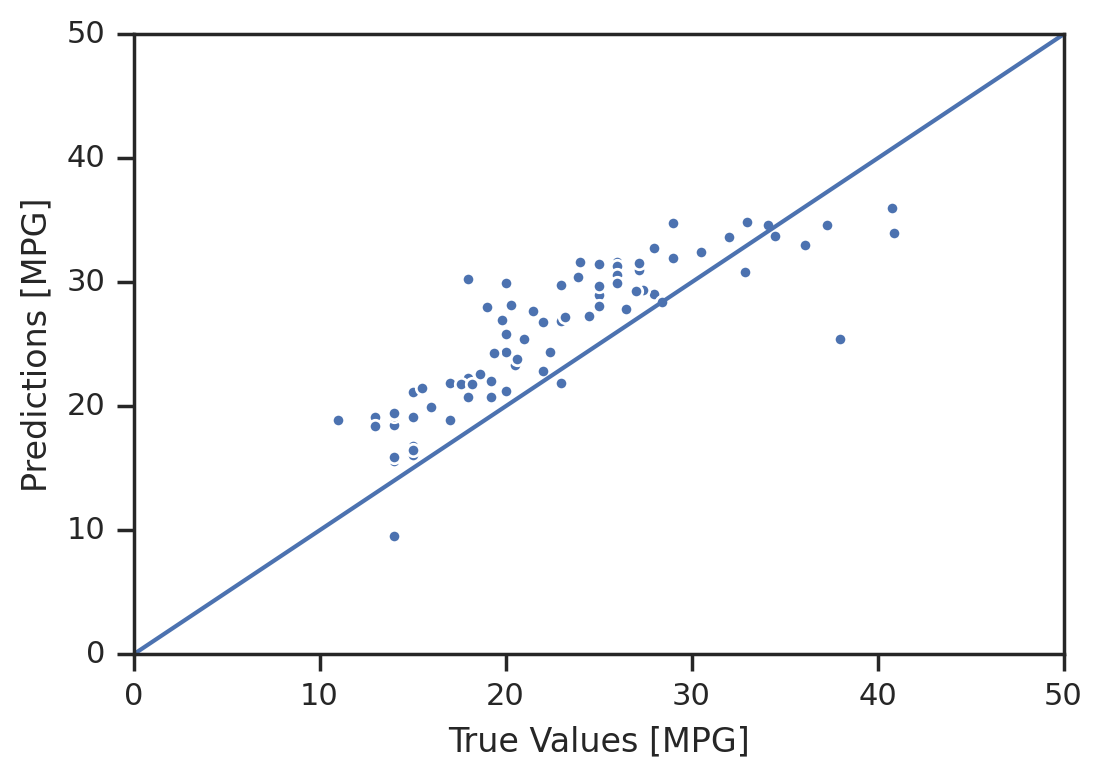

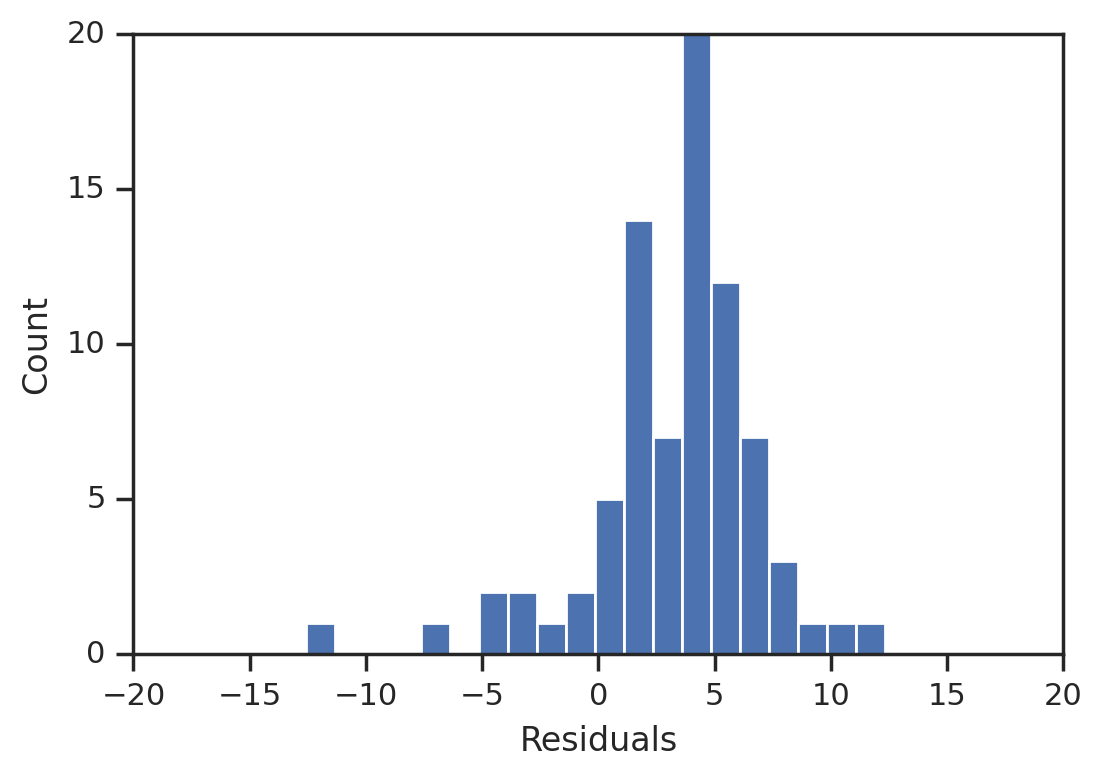

In [ ]:
Y_predicted = dnn_model.predict(X_test).flatten()
show_predicted_vs_true(Y_test, Y_predicted)
prediction_error(Y_test, Y_predicted)